#Data

In [ ]:
!gdown "1--2MHS70-Y8rZfsDd5PjztPevBC6Q5vd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1--2MHS70-Y8rZfsDd5PjztPevBC6Q5vd&confirm=t
To: /content/flickr8kimagescaptions.zip
100% 1.11G/1.11G [00:04<00:00, 249MB/s]


In [ ]:
!unzip flickr8kimagescaptions.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

#Library

In [ ]:
import os
import cv2
from tqdm import tqdm
import torch 
import random
import torchtext
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from textwrap import wrap
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torchtext.data import get_tokenizer
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from nltk.translate.bleu_score import corpus_bleu
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

#Visualize sample

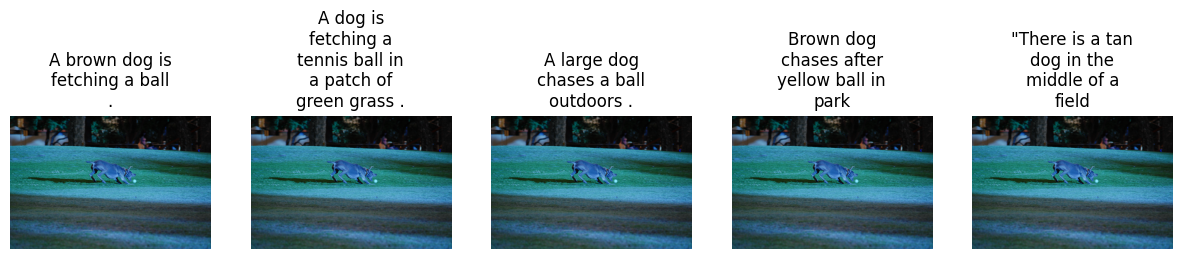

In [ ]:
#Load captions
captions = open("/content/flickr8k/captions.txt")

captions = [line.strip().split(",") for line in captions]
dict_image_caption = {}

for i, item in enumerate(captions):
  if i==0:
    continue
  if item[0] in dict_image_caption.keys():
    dict_image_caption[item[0]].append(item[1])
  else:
    dict_image_caption[item[0]]= [item[1]]

keys = random.sample(list(dict_image_caption), 1)

for key in keys:
  img = cv2.imread(os.path.join("/content/flickr8k/images", key))
  plt.figure(figsize=(15, 15))
  for i,caption in enumerate(dict_image_caption[key]):
    ax = plt.subplot(1, len( dict_image_caption[key]), i + 1)
    caption = "\n".join(wrap(caption, 15))
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
  plt.show()

#Customize dataloader

In [ ]:
# write dataloader 

PAD_VALUE = 0

class MyDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None, tokenizer="spacy"):
        super(MyDataset, self).__init__()
        ############################################
        # your code here, you can add new parameter in constructor
        ############################################
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = get_tokenizer(tokenizer)

        with open(annotation_dir) as f:
            self.img_caption_pair = f.readlines()
        self.img_caption_pair = self.img_caption_pair[1:]
        # each element of list is a tuple: (img_name, caption)
        self.img_caption_pair = [self.split_img_caption(line) for line in self.img_caption_pair]
        # dict[img] = [cap1, cap2, cap3, cap4, cap5]
        self.img_caption_dict = {}
        self.build_img_cap_dict()
        
        self.vocab = {"<PAD>": PAD_VALUE, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.build_vocab()        
        self.idx_to_vocab = {self.vocab[k]:k for k in self.vocab.keys()}


    def preprocess_caption(self, caption):
        # remove " from the beginning and the end of a caption
        if caption.startswith('"'):
            caption = caption[1:]
        if caption.endswith('"'):
            caption = caption[:-1]

        # convert characters to lower case
        caption = caption.lower()
        return caption


    def split_img_caption(self, l):
        img, *cap = l.strip().split(',')
        # if the caption itself has comma, join the other parts of it
        cap = ','.join(cap)
        cap = self.preprocess_caption(cap)

        return (img, cap)


    def build_img_cap_dict(self):
        for img, cap in self.img_caption_pair:
            if img in self.img_caption_dict.keys():
                self.img_caption_dict[img].append(cap)
            else: self.img_caption_dict[img] = [cap]


    def build_vocab(self):
        idx = 4
        for _, c in self.img_caption_pair:
            tokens = self.tokenizer(c)
            for t in tokens:
                if t not in self.vocab.keys():
                    self.vocab[t] = idx
                    idx += 1 


    def build_vocab_from_words(self, words):
        self.vocab = {}
        c = 0
        for w in words:
            self.vocab[w] = c
            c += 1

        # index_to_vocab dictionary should be updated
        self.idx_to_vocab = {self.vocab[k]:k for k in self.vocab.keys()}


    def __len__(self):
        ###########################################
        #your code here, you should be return size of vocabulary here
        ###########################################

        # return len(self.vocab)
        return len(self.img_caption_pair)

    def __getitem__(self, index):
        ############################################
        #your code here, you should be retrun image and caption of that, please attention caption of image tokenized and cleaned
        ############################################   

        # read image
        img_name, caption = self.img_caption_pair[index]
        img = cv2.imread(os.path.join(self.img_dir, img_name))
        if self.transform:
            img = self.transform(Image.fromarray(img))

        # tokenize caption and get its index
        tokenized_caption = self.tokenizer(caption)

        indices = [self.vocab["<SOS>"]]
        for t in tokenized_caption:
            if t in self.vocab.keys():
                idx = self.vocab[t]
            else: idx = self.vocab["<UNK>"]
            indices.append(idx)

        indices.append(self.vocab["<EOS>"])
        return img, indices


In [ ]:
def padify(batch):
    images = []
    captions = []

    for i, c in batch:
        images.append(i)
        captions.append(torch.tensor(c))

    padded_caps = pad_sequence(captions, batch_first=False, padding_value=PAD_VALUE)
    return (torch.stack(images),
            padded_caps)
    
    
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )    

In [ ]:
dataset = MyDataset("/content/flickr8k/images", "/content/flickr8k/captions.txt", transform=transform)

####################################################
#your code here 
###################################################
batch_size = 64

train_split = 0.8
train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=padify)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=padify)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [ ]:
print(len(dataset))
print(len(dataset.vocab))
print(len(train_loader.dataset))
print(len(val_loader.dataset))

40455
8508
32364
8091


#Model

In [ ]:
class ImageCaptioning(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(ImageCaptioning, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # backbone for feature exctract
        self.featuresCNN = models.resnet50(pretrained=True)
        # convert features to feature vector
        for param in self.featuresCNN.parameters():
            param.requires_grad = False
        self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        #activation function
        self.relu = nn.ReLU()
        #RNN
        # I added padding_idx
        self.embed = nn.Embedding(self.vocab_size, self.embed_size, padding_idx=PAD_VALUE)
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers)
        self.linear = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, images, captions):
        features = self.featuresCNN(images)
        features = self.relu(features)
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.fc(hiddens)
        return outputs

    def predict_caption(self, image, idx_to_vocab, maxlength=40):
        result_caption = []
        
        with torch.no_grad():
            x = self.featuresCNN(image)
            x = self.relu(x).unsqueeze(0)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.lstm(x, states)
                output = self.fc(hiddens.squeeze(0))
                predicted = output.argmax(1)
                
                result_caption.append(predicted.item())
                x = self.embed(predicted).unsqueeze(0)
                
                if idx_to_vocab[predicted.item()] == "<EOS>":
                    break
        return [idx_to_vocab[i] for i in result_caption]


#Train

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

num_epochs = 10
vocab_size = len(dataset.vocab)
embed_size = 256
hidden_size = 256
num_layers = 3
learning_rate = 1e-3

device: cuda


In [ ]:
####################################
#your code here, complete num_epochs, model, optimizer, loss function
######################################

model = ImageCaptioning(vocab_size, embed_size, hidden_size, num_layers)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")

    # train loop
    running_loss = 0
    model.train()
    # CHANGE to train_loader
    for idx, (imgs, captions) in enumerate(tqdm(train_loader)):
        ####################################
        #your code here, complete train loop
        ######################################
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        pred = model(imgs, captions[:-1])
        optimizer.zero_grad()
        loss = criterion(pred.reshape(-1, pred.shape[2]), captions.reshape(-1))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader)
    print("Train Loss:", running_loss)

    # evaluation loop
    eval_loss = 0
    model.eval() 
    with torch.no_grad():
        for idx, (imgs, captions) in enumerate(tqdm(val_loader)):
        ###################################
        # your code here, complete validation loop
        #####################################
            imgs = imgs.to(device)
            captions = captions.to(device)
            
            pred = model(imgs, captions[:-1])
            loss = criterion(pred.reshape(-1, pred.shape[2]), captions.reshape(-1))
            eval_loss += loss.item()
    eval_loss /= len(val_loader)
    print("Eval Loss:", eval_loss)
  
    print("*"*50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Epoch 1


100%|██████████| 506/506 [06:08<00:00,  1.37it/s]


Train Loss: 2.7491757448011707


100%|██████████| 127/127 [01:25<00:00,  1.49it/s]


Eval Loss: 2.261204177000391
**************************************************
Epoch 2


100%|██████████| 506/506 [05:56<00:00,  1.42it/s]


Train Loss: 2.062711037194776


100%|██████████| 127/127 [01:24<00:00,  1.51it/s]


Eval Loss: 1.9737005646773211
**************************************************
Epoch 3


100%|██████████| 506/506 [05:51<00:00,  1.44it/s]


Train Loss: 1.8527477378901758


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.8453665051873274
**************************************************
Epoch 4


100%|██████████| 506/506 [05:54<00:00,  1.43it/s]


Train Loss: 1.7473391402851453


100%|██████████| 127/127 [01:23<00:00,  1.51it/s]


Eval Loss: 1.7636045930892463
**************************************************
Epoch 5


100%|██████████| 506/506 [05:50<00:00,  1.44it/s]


Train Loss: 1.6457291823837596


100%|██████████| 127/127 [01:24<00:00,  1.51it/s]


Eval Loss: 1.6854843483196469
**************************************************
Epoch 6


100%|██████████| 506/506 [05:49<00:00,  1.45it/s]


Train Loss: 1.554649254785696


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.6305737195052499
**************************************************
Epoch 7


100%|██████████| 506/506 [05:54<00:00,  1.43it/s]


Train Loss: 1.4803795881657733


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.587299199554864
**************************************************
Epoch 8


100%|██████████| 506/506 [05:51<00:00,  1.44it/s]


Train Loss: 1.412818374252131


100%|██████████| 127/127 [01:23<00:00,  1.52it/s]


Eval Loss: 1.559513425263833
**************************************************
Epoch 9


100%|██████████| 506/506 [05:49<00:00,  1.45it/s]


Train Loss: 1.3574818484632394


100%|██████████| 127/127 [01:23<00:00,  1.53it/s]


Eval Loss: 1.5363937991810597
**************************************************
Epoch 10


100%|██████████| 506/506 [05:48<00:00,  1.45it/s]


Train Loss: 1.30267662481357


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]

Eval Loss: 1.523096230555707
**************************************************


# BLEU

In [ ]:
def compute_bleu(list_of_references, hypotheses):
    weights = [
        (1., 0, 0, 0),
        (1./2., 1./2., 0, 0)
    ]
    
    return corpus_bleu(list_of_references, hypotheses, weights=weights)

In [ ]:
def predict_whole_data(dataset, model):
    references = []
    hypotheses = []

    # compute bleu on whole data
    for img_name, caps in dataset.img_caption_dict.items():

        # read image
        img = cv2.imread(os.path.join(dataset.img_dir, img_name))
        if transform:
            img = transform(Image.fromarray(img))

        img = img.to(device)
        predicted_caption = model.predict_caption(img.unsqueeze(0), dataset.idx_to_vocab)
        if '<SOS>' in predicted_caption:
            predicted_caption.remove('<SOS>')
        if '<EOS>' in predicted_caption:
            predicted_caption.remove('<EOS>')
            
        # print(predicted_caption)
        hypotheses.append(predicted_caption)

        tokenized_captions = [dataset.tokenizer(cap) for cap in caps]
        # print(tokenized_captions)
        references.append(tokenized_captions)
    
    return references, hypotheses

In [ ]:
references, hypotheses = predict_whole_data(dataset, model)
bleu1, bleu2 = compute_bleu(references, hypotheses)
print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)

BLEU-1: 0.5575184961055694
BLEU-2: 0.3455166215514869


#Change Model

## Build Glove Vocab

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2023-05-17 17:35:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-17 17:35:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-17 17:35:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
vocab, embeddings = [],[]
# use embedding_size 200 from glove
with open('glove.6B.200d.txt','rt') as f:
    full_content = f.read().strip().split('\n')

for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [ ]:
vocab_np = np.array(vocab)
embeds_np = np.array(embeddings)

#insert '<PAD>' and '<UNK>' tokens at start of vocab_np.
vocab_np = np.insert(vocab_np, 0, '<PAD>')
vocab_np = np.insert(vocab_np, 1, '<SOS>')
vocab_np = np.insert(vocab_np, 2, '<EOS>')
vocab_np = np.insert(vocab_np, 3, '<UNK>')
# print(vocab_np[:10])

pad_emb_np = np.zeros((1, embeds_np.shape[1]))   #embedding for '<PAD>' token.
sos_emb_np = np.random.rand(1, embeds_np.shape[1])   #embedding for '<SOS>' token.
eos_emb_np = np.random.rand(1, embeds_np.shape[1])   #embedding for '<EOS>' token.
unk_emb_np = np.mean(embeds_np, axis=0, keepdims=True)    #embedding for '<UNK>' token.

#insert embeddings for pad, sos, eos, unk tokens at top of embeds_np.
embeds_np = np.vstack((pad_emb_np, sos_emb_np, eos_emb_np, unk_emb_np, embeds_np))
print(embeds_np.shape)

(400004, 200)


In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

dataset_glove = MyDataset("/content/flickr8k/images", "/content/flickr8k/captions.txt", transform=transform)

batch_size = 64

train_split = 0.8
train_size = int(train_split * len(dataset_glove))
val_size = len(dataset_glove) - train_size

train_set2, val_set2 = random_split(dataset_glove, [train_size, val_size])

train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size, shuffle=True, collate_fn=padify)
val_loader2 = torch.utils.data.DataLoader(val_set2, batch_size=batch_size, shuffle=False, collate_fn=padify)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [ ]:
# a boolean array of same shape as vocab_np
mask = np.isin(vocab_np, np.array(list(dataset_glove.vocab.keys())))
print("mask:", mask)
# indices of words which are common in both (glove_vocab and dataset_vocab)
intersection = np.argwhere(mask)
intersection = np.squeeze(intersection, 1)
print("intersection", intersection)

reduced_vocab = vocab_np[intersection]
reduced_embeds = embeds_np[intersection]
print(reduced_vocab[:20])

# update dataset vocabulary
dataset_glove.build_vocab_from_words(reduced_vocab)

mask: [ True  True  True ... False False False]
intersection [     0      1      2 ... 396597 398567 399875]
['<PAD>' '<SOS>' '<EOS>' '<UNK>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a'
 '"' "'s" 'for' '-' 'that' 'on' 'is' 'was']


In [ ]:
print(len(dataset_glove.vocab))
print(reduced_vocab.shape)

7846
(7846,)


## Define new model

In [ ]:
class ImageCaptioningPretrained(ImageCaptioning):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, embeddings):
        super(ImageCaptioningPretrained, self).__init__(vocab_size, embed_size, hidden_size, num_layers)
        
        # different from the previous part
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), padding_idx=PAD_VALUE)

## Train

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

num_epochs = 10
vocab_size = len(dataset_glove.vocab)
embed_size = 200
hidden_size = 200
num_layers = 3
learning_rate = 1e-3

device: cuda


In [ ]:
model_pretrained = ImageCaptioningPretrained(vocab_size, embed_size, hidden_size, num_layers, reduced_embeds)
model_pretrained.to(device)
optimizer2 = optim.Adam(model_pretrained.parameters(), lr=learning_rate)
criterion2 = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")

    # train loop
    running_loss = 0
    model_pretrained.train()

    for idx, (imgs, captions) in enumerate(tqdm(train_loader2)):
        ####################################
        #your code here, complete train loop
        ######################################
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        pred = model_pretrained(imgs, captions[:-1])
        optimizer2.zero_grad()
        loss = criterion2(pred.reshape(-1, pred.shape[2]), captions.reshape(-1))
        
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()

    running_loss /= len(train_loader2)
    print("Train Loss:", running_loss)

    # evaluation loop
    eval_loss = 0
    model_pretrained.eval() 
    with torch.no_grad():
        for idx, (imgs, captions) in enumerate(tqdm(val_loader2)):
        ###################################
        # your code here, complete validation loop
        #####################################
            imgs = imgs.to(device)
            captions = captions.to(device)
            
            pred = model_pretrained(imgs, captions[:-1])
            loss = criterion2(pred.reshape(-1, pred.shape[2]), captions.reshape(-1))
            eval_loss += loss.item()
    eval_loss /= len(val_loader2)
    print("Eval Loss:", eval_loss)
  
    print("*"*50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


Epoch 1


100%|██████████| 506/506 [06:02<00:00,  1.39it/s]


Train Loss: 2.8903727321756687


100%|██████████| 127/127 [01:24<00:00,  1.49it/s]


Eval Loss: 2.3872270415148398
**************************************************
Epoch 2


100%|██████████| 506/506 [05:52<00:00,  1.44it/s]


Train Loss: 2.160399492314682


100%|██████████| 127/127 [01:24<00:00,  1.51it/s]


Eval Loss: 2.0730672567848147
**************************************************
Epoch 3


100%|██████████| 506/506 [05:48<00:00,  1.45it/s]


Train Loss: 1.9235348213802685


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.8981473286320845
**************************************************
Epoch 4


100%|██████████| 506/506 [05:50<00:00,  1.44it/s]


Train Loss: 1.7973678368824744


100%|██████████| 127/127 [01:33<00:00,  1.36it/s]


Eval Loss: 1.8083393113819632
**************************************************
Epoch 5


100%|██████████| 506/506 [06:00<00:00,  1.40it/s]


Train Loss: 1.7051508106261846


100%|██████████| 127/127 [01:25<00:00,  1.49it/s]


Eval Loss: 1.7323606661924227
**************************************************
Epoch 6


100%|██████████| 506/506 [05:49<00:00,  1.45it/s]


Train Loss: 1.6367170751801592


100%|██████████| 127/127 [01:23<00:00,  1.51it/s]


Eval Loss: 1.6731525922384787
**************************************************
Epoch 7


100%|██████████| 506/506 [05:48<00:00,  1.45it/s]


Train Loss: 1.5663855751983733


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.6271703308961523
**************************************************
Epoch 8


100%|██████████| 506/506 [05:47<00:00,  1.45it/s]


Train Loss: 1.5141459580937864


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.5910822904016089
**************************************************
Epoch 9


100%|██████████| 506/506 [05:51<00:00,  1.44it/s]


Train Loss: 1.4750279853702062


100%|██████████| 127/127 [01:24<00:00,  1.51it/s]


Eval Loss: 1.5633375776095653
**************************************************
Epoch 10


100%|██████████| 506/506 [05:50<00:00,  1.44it/s]


Train Loss: 1.4285901988683483


100%|██████████| 127/127 [01:23<00:00,  1.51it/s]

Eval Loss: 1.5406883438741128
**************************************************


## BLEU

In [ ]:
print(dataset_glove.idx_to_vocab)
print(dataset_glove.vocab)

{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'the', 5: ',', 6: '.', 7: 'of', 8: 'to', 9: 'and', 10: 'in', 11: 'a', 12: '"', 13: "'s", 14: 'for', 15: '-', 16: 'that', 17: 'on', 18: 'is', 19: 'was', 20: 'with', 21: 'he', 22: 'as', 23: 'it', 24: 'by', 25: 'at', 26: '(', 27: ')', 28: 'from', 29: 'his', 30: 'an', 31: 'be', 32: 'has', 33: 'are', 34: 'have', 35: 'but', 36: 'were', 37: 'not', 38: 'this', 39: 'who', 40: 'they', 41: 'had', 42: 'i', 43: 'which', 44: 'will', 45: 'their', 46: ':', 47: 'or', 48: 'its', 49: 'one', 50: 'after', 51: 'new', 52: 'been', 53: 'also', 54: 'we', 55: 'would', 56: 'two', 57: 'more', 58: "'", 59: 'first', 60: 'about', 61: 'up', 62: 'when', 63: 'year', 64: 'there', 65: 'all', 66: 'out', 67: 'she', 68: 'other', 69: 'people', 70: "n't", 71: 'her', 72: 'than', 73: 'over', 74: 'into', 75: 'last', 76: 'some', 77: 'government', 78: 'time', 79: 'you', 80: 'if', 81: 'no', 82: 'world', 83: 'can', 84: 'three', 85: 'do', 86: ';', 87: 'only', 88: 'state', 89: 'us', 9

In [ ]:
references, hypotheses = predict_whole_data(dataset_glove, model_pretrained)
bleu1, bleu2 = compute_bleu(references, hypotheses)
print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)

BLEU-1: 0.5240019886572881
BLEU-2: 0.31634241107845434


#Train Again

## Define model

In [ ]:
class ImageCaptioningFinetuneResnet(ImageCaptioning):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, embeddings):
        super(ImageCaptioningFinetuneResnet, self).__init__(vocab_size, embed_size, hidden_size, num_layers)
        
        for name, param in self.featuresCNN.named_parameters():
            if 'layer4.2' in name or 'layer4.1' in name:
                continue
            param.requires_grad = False
            # print(name)

        self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)

        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), padding_idx=PAD_VALUE)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

num_epochs = 10
vocab_size = len(dataset_glove.vocab)
embed_size = 200
hidden_size = 200
num_layers = 3
learning_rate = 1e-3

device: cuda


## Train

In [ ]:
model_finetune_resnet = ImageCaptioningFinetuneResnet(vocab_size, embed_size, hidden_size, num_layers, reduced_embeds)
model_finetune_resnet.to(device)
optimizer2 = optim.Adam(model_finetune_resnet.parameters(), lr=learning_rate)
criterion2 = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")

    # train loop
    running_loss = 0
    model_finetune_resnet.train()

    for idx, (imgs, captions) in enumerate(tqdm(train_loader2)):
        ####################################
        #your code here, complete train loop
        ######################################
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        pred = model_finetune_resnet(imgs, captions[:-1])
        optimizer2.zero_grad()
        loss = criterion2(pred.reshape(-1, pred.shape[2]), captions.reshape(-1))
        
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()

    running_loss /= len(train_loader2)
    print("Train Loss:", running_loss)

    # evaluation loop
    eval_loss = 0
    model_finetune_resnet.eval() 
    with torch.no_grad():
        for idx, (imgs, captions) in enumerate(tqdm(val_loader2)):
        ###################################
        # your code here, complete validation loop
        #####################################
            imgs = imgs.to(device)
            captions = captions.to(device)
            
            pred = model_finetune_resnet(imgs, captions[:-1])
            loss = criterion2(pred.reshape(-1, pred.shape[2]), captions.reshape(-1))
            eval_loss += loss.item()
    eval_loss /= len(val_loader2)
    print("Eval Loss:", eval_loss)
  
    print("*"*50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


Epoch 1


100%|██████████| 506/506 [06:07<00:00,  1.38it/s]


Train Loss: 2.8924215056679468


100%|██████████| 127/127 [01:25<00:00,  1.48it/s]


Eval Loss: 2.2913984229245523
**************************************************
Epoch 2


100%|██████████| 506/506 [05:57<00:00,  1.42it/s]


Train Loss: 2.1378590271406965


100%|██████████| 127/127 [01:25<00:00,  1.49it/s]


Eval Loss: 1.9961898655403318
**************************************************
Epoch 3


100%|██████████| 506/506 [05:55<00:00,  1.42it/s]


Train Loss: 1.9337210963837244


100%|██████████| 127/127 [01:25<00:00,  1.48it/s]


Eval Loss: 1.8522482162385474
**************************************************
Epoch 4


100%|██████████| 506/506 [05:55<00:00,  1.42it/s]


Train Loss: 1.805910297062086


100%|██████████| 127/127 [01:25<00:00,  1.49it/s]


Eval Loss: 1.7621322363380372
**************************************************
Epoch 5


100%|██████████| 506/506 [05:53<00:00,  1.43it/s]


Train Loss: 1.7172745810195862


100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


Eval Loss: 1.6988021379380713
**************************************************
Epoch 6


100%|██████████| 506/506 [05:54<00:00,  1.43it/s]


Train Loss: 1.6491905919647971


100%|██████████| 127/127 [01:26<00:00,  1.48it/s]


Eval Loss: 1.6562527446296271
**************************************************
Epoch 7


100%|██████████| 506/506 [05:52<00:00,  1.44it/s]


Train Loss: 1.5866548351855145


100%|██████████| 127/127 [01:26<00:00,  1.47it/s]


Eval Loss: 1.604901394506139
**************************************************
Epoch 8


100%|██████████| 506/506 [05:50<00:00,  1.44it/s]


Train Loss: 1.5438391149279629


100%|██████████| 127/127 [01:23<00:00,  1.52it/s]


Eval Loss: 1.5661863041674997
**************************************************
Epoch 9


100%|██████████| 506/506 [05:52<00:00,  1.44it/s]


Train Loss: 1.482220013504443


100%|██████████| 127/127 [01:23<00:00,  1.52it/s]


Eval Loss: 1.536145264708151
**************************************************
Epoch 10


100%|██████████| 506/506 [05:49<00:00,  1.45it/s]


Train Loss: 1.4399805086639088


100%|██████████| 127/127 [01:24<00:00,  1.51it/s]

Eval Loss: 1.5082164923037131
**************************************************


## BLEU

In [ ]:
references, hypotheses = predict_whole_data(dataset_glove, model_finetune_resnet)
bleu1, bleu2 = compute_bleu(references, hypotheses)
print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)

BLEU-1: 0.5225900808585162
BLEU-2: 0.31742193678211106
